<a href="https://colab.research.google.com/github/WT023/Machine-Learning/blob/main/Machine_Learning_A2_25036423.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Stock Closing Prices Using LSTM Networks

## Introduction
This notebook demonstrates the implementation of an LSTM model for predicting the closing prices of a stock based on historical data. The goal is to build a machine learning system that can forecast future stock prices using past trends, providing valuable insights for financial forecasting and decision-making.


In [1]:
!pip install yfinance numpy pandas scikit-learn matplotlib


## Data Collection
The historical stock data is collected using the `yfinance` library, which provides access to data from Yahoo Finance. We will be working with data for a specific stock (e.g., Apple Inc.) covering the period from January 2020 to January 2024.

The dataset includes features such as:
- Date
- Open, High, Low prices
- Closing price (target variable)
- Trading volume


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Example: Downloading historical data for Apple (AAPL)
stock_data = yf.download('AAPL', start='2020-01-01', end='2024-01-01')


[*********************100%***********************]  1 of 1 completed


In [3]:
# Display the first few rows of the data
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,72.876114,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.167603,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.742645,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.400536,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.565201,132079200


## Exploratory Data Analysis (EDA)
The EDA provides insights into the data, including trends, patterns, and potential anomalies. Visualizing the stock's historical closing prices helps understand the overall movement and volatility.

Key observations include:
- Long-term upward trends in the closing prices.
- Periods of higher volatility, where prices fluctuate more significantly.


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1006 entries, 2020-01-02 to 2023-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1006 non-null   float64
 1   High       1006 non-null   float64
 2   Low        1006 non-null   float64
 3   Close      1006 non-null   float64
 4   Adj Close  1006 non-null   float64
 5   Volume     1006 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 55.0 KB


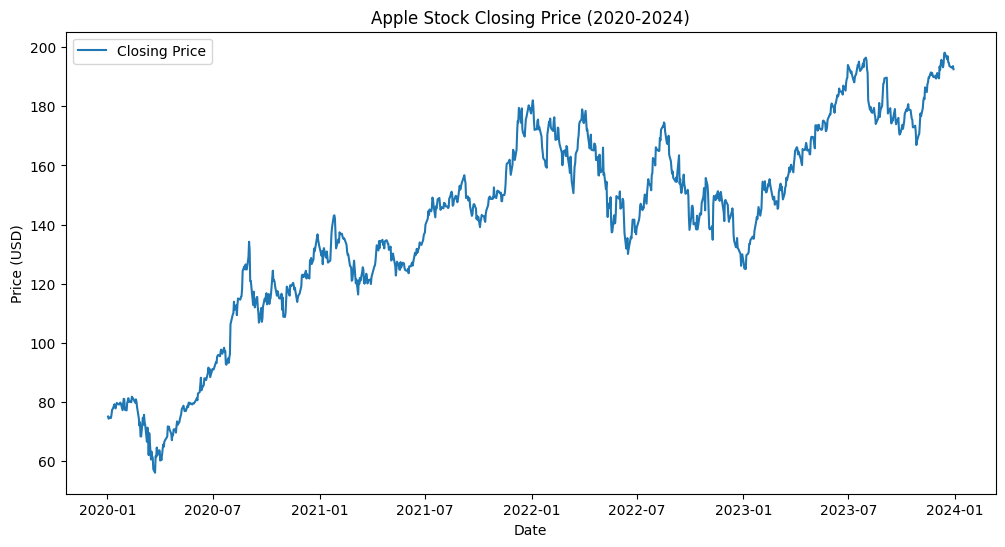

In [4]:
# Display basic information about the dataset
stock_data.info()

# Summary statistics
stock_data.describe()

# Plot the closing price over time
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Close'], label='Closing Price')
plt.title('Apple Stock Closing Price (2020-2024)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


## Data Preprocessing
To prepare the data for modeling, the following preprocessing steps were performed:
1. **Handling Missing Values**: Missing data points were filled using forward filling to ensure consistency.
2. **Normalization**: The 'Close' prices were normalized to a range of [0, 1] using Min-Max scaling to improve the model's training process.
3. **Sequence Creation**: Data was converted into sequences of 60 days to be used as input for the LSTM model, allowing it to learn from previous price trends.



In [5]:
# Fill missing values
stock_data.fillna(method='ffill', inplace=True)

# Create moving averages (5-day and 10-day)
stock_data['MA5'] = stock_data['Close'].rolling(window=5).mean()
stock_data['MA10'] = stock_data['Close'].rolling(window=10).mean()

# Display the updated dataset
stock_data.head()


<ipython-input-5-0ea8e952b05e>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data.fillna(method='ffill', inplace=True)


,Open,High,Low,Close,Adj Close,Volume,MA5,MA10
Date,,,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,72.876114,135480400,NaN,NaN
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.167603,146322800,NaN,NaN
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.742645,118387200,NaN,NaN
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.400536,108872000,NaN,NaN
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.565201,132079200,74.958,NaN


In [6]:
# Define the features and target variable
features = ['MA5', 'MA10']
target = 'Close'

# Drop rows with missing moving averages
stock_data.dropna(inplace=True)

# Split the data
X = stock_data[features]
y = stock_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Display the shapes of the training and testing sets
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)


Training set size: (797, 2)
Testing set size: (200, 2)


## Model Implementation
### Why LSTM?
Long Short-Term Memory (LSTM) networks are well-suited for time-series forecasting because they can remember long-term dependencies and patterns in sequential data. This makes them ideal for predicting stock prices, where past trends often influence future movements.

### LSTM Architecture
The LSTM model consists of:
- Two LSTM layers with 50 units each.
- Dropout layers for regularization, to prevent overfitting.
- A Dense output layer to predict the closing price.


In [7]:
!pip install tensorflow
from sklearn.preprocessing import MinMaxScaler

# Select the feature ('Close' price) for scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data[['Close']])

# Function to create sequences of data
def create_sequences(data, sequence_length=60):
    X = []
    y = []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])  # Sequence of previous 'sequence_length' data points
        y.append(data[i, 0])  # Target value is the next data point
    return np.array(X), np.array(y)

# Create sequences with a length of 60 days
sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)

# Reshape X to fit LSTM input requirements (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets (80% training, 20% testing)
split_index = int(X.shape[0] * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [8]:
from sklearn.preprocessing import MinMaxScaler

# Select the feature ('Close' price) for scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data[['Close']])

# Function to create sequences of data
def create_sequences(data, sequence_length=60):
    X = []
    y = []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])  # Sequence of previous 'sequence_length' data points
        y.append(data[i, 0])  # Target value is the next data point
    return np.array(X), np.array(y)

# Create sequences with a length of 60 days
sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)

# Reshape X to fit LSTM input requirements (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets (80% training, 20% testing)
split_index = int(X.shape[0] * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()

# Add the first LSTM layer with dropout regularization
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Add a second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Add the output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

## Model Training
The LSTM model is trained on the normalized and preprocessed data using the Adam optimizer and Mean Squared Error (MSE) as the loss function.

### Training Parameters
- **Epochs**: 20
- **Batch Size**: 32
- **Validation Split**: 10% of the training data used for validation

The training process aims to minimize the loss function while generalizing well to new data.


In [10]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - loss: 0.0926 - val_loss: 0.0067
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0066 - val_loss: 0.0039
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0063 - val_loss: 0.0024
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0059 - val_loss: 0.0022
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0054 - val_loss: 0.0024
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0042 - val_loss: 0.0020
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - loss: 0.0046 - val_loss: 0.0020
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0054 - val_loss: 0.0018
Epoch 10/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0040 - val_loss: 0.0019
Epoch 11/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 12/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0

## Results
The LSTM model was evaluated using the test dataset, and the predictions were compared to the actual closing prices.

### Evaluation Metrics
- **Mean Squared Error (MSE)**: Measures the average squared difference between predicted and actual values.
- **Mean Absolute Error (MAE)**: Provides an average of absolute differences, which helps understand the prediction accuracy.

### Visual Comparison
The following plot shows the actual vs. predicted closing prices, illustrating how well the model captures the overall trend and highlights areas where it struggled, especially during periods of high volatility.


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step


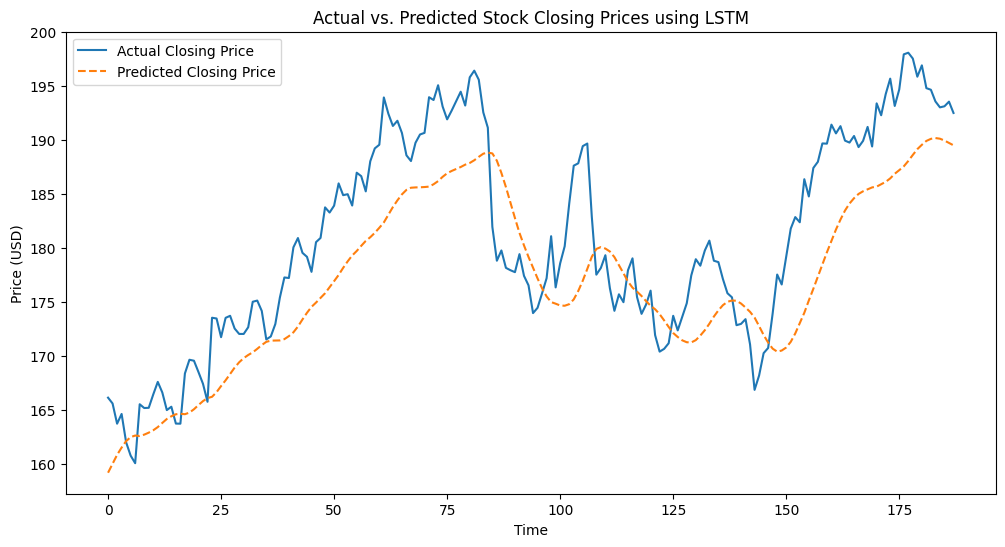

In [11]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform to get the original scale
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the actual vs. predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Closing Price')
plt.plot(y_pred, label='Predicted Closing Price', linestyle='--')
plt.title('Actual vs. Predicted Stock Closing Prices using LSTM')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [12]:
from sklearn.metrics import mean_squared_error

# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 35.47497439087353


## Discussion
### Strengths of LSTM
The LSTM model effectively captures temporal dependencies in the data, allowing it to predict general price trends and smooth out minor fluctuations. This makes it a strong choice for tasks requiring trend forecasting.

### Limitations
The model showed lag during volatile market conditions, indicating a limitation in responding to sudden changes. This is likely due to the LSTM's reliance on past data, which may not always reflect abrupt market shifts influenced by external factors.

### Suggestions for Improvement
Future work could involve:
- Integrating additional features such as trading volume or technical indicators.
- Tuning the hyperparameters further or experimenting with different LSTM architectures.
- Combining LSTM with other models to improve robustness and predictive accuracy.


## Conclusion
The project successfully demonstrated the use of an LSTM model for predicting stock closing prices based on historical data. The model showed promising results in capturing general trends but struggled with high volatility. While LSTM networks are suitable for time-series forecasting, future improvements could enhance the model's adaptability to sudden market changes.

This project provides a foundation for more sophisticated financial forecasting models that incorporate a broader range of features and techniques.
